<h1><center>ROOFIT</center></h1>
<h2><center>PART 2</center></h2>

Following from Part 1, this notebook will give a tutorial on the more advanced parts of RooFit, things most people do not use.



In [3]:
import ROOT

Welcome to JupyROOT 6.22/00


# Integrals of Models

Models can be integrated, via the `createIntegral()` method. It will return the raw value of the PDF, i.e unnormalized to unity.


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization -- RooMinimizer::optimizeConst: deactivating const optimization
RooRealIntegral::gaus_Int[x][ Int gausd[Ana](x) ] = 12.5


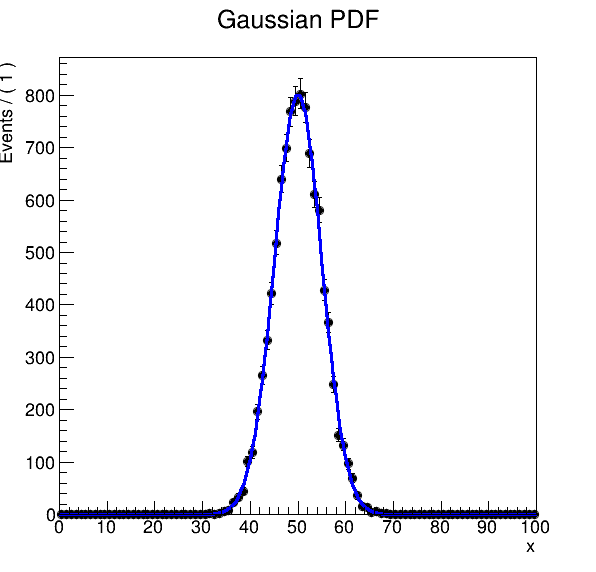

In [4]:
# build a model
x = ROOT.RooRealVar("x", "x", 0, 100)
m = ROOT.RooRealVar("m", "gaussian mean", 50, 40, 60)
s = ROOT.RooRealVar("s", "gaussian width", 5, 3, 7)

gaus = ROOT.RooGaussian("gaus", "gaussian pdf", x, m, s)

# generate events
gausData = gaus.generate(x, 10000)

# fit the pdf to the dataset
gaus.fitTo(gausData, ROOT.RooFit.PrintLevel(-1))

# get the integral along x
gausInt = gaus.createIntegral(x)
gausInt.Print()

# plot the the model and dataset
canv   = ROOT.TCanvas("canv", "canv", 600, 600)
xframe = x.frame(ROOT.RooFit.Title("Gaussian PDF"))

gausData.plotOn(xframe)
gaus.plotOn(xframe)
xframe.Draw()
canv.Draw()

# Cumulative Distribution Function

A special form of an integral that can be constructed via `createCdf()`.

RooRealIntegral::gaus_cdf_Int[x_prime|CDF]_Norm[x_prime][ Int gaus_cdf_Norm(x_prime) d[Ana](x_prime) ] = 0.497341


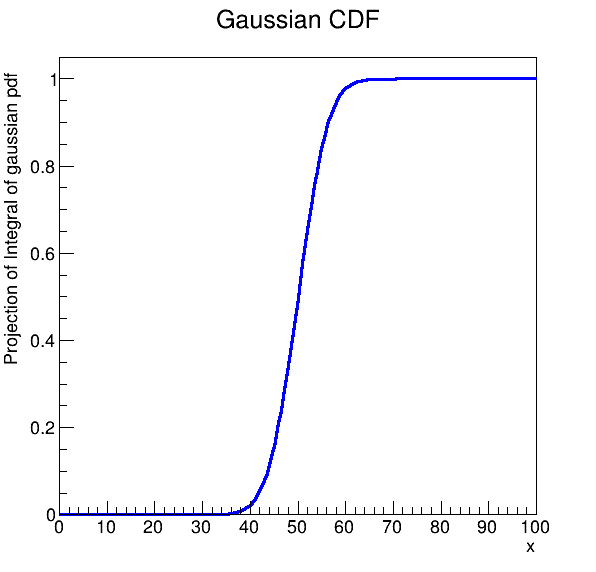

In [5]:
gausCdf = gaus.createCdf(x)
gausCdf.Print()

xframe = x.frame(ROOT.RooFit.Title("Gaussian CDF"))
gausCdf.plotOn(xframe)

canv.Clear()
xframe.Draw()
canv.Draw()


# PDF Derivatives

You can also create PDF derivatives from present PDFs, given parameters and observables.

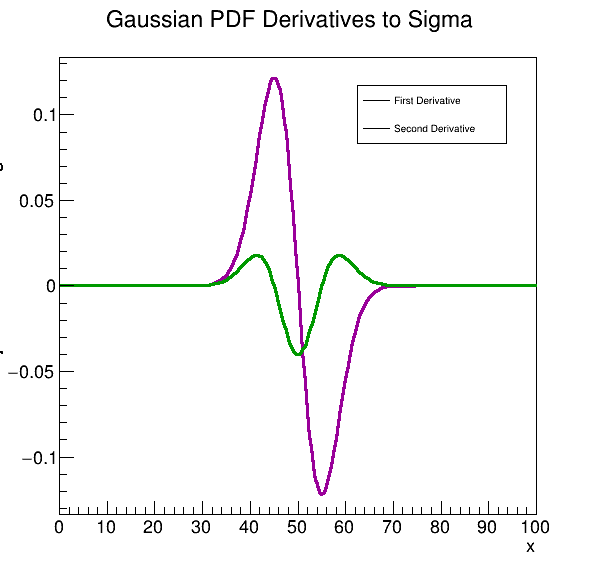

In [6]:
# first derivative
dg1 = gaus.derivative(x, 1)

# second derivative
dg2 = gaus.derivative(x, 2)

xframe = x.frame(ROOT.RooFit.Title("Gaussian PDF Derivatives to Sigma"))
dg1.plotOn(xframe, ROOT.RooFit.LineColor(ROOT.kMagenta+2), ROOT.RooFit.Name("dg1"))
dg2.plotOn(xframe, ROOT.RooFit.LineColor(ROOT.kGreen+2), ROOT.RooFit.Name("dg2"))

lgd = ROOT.TLegend(0.6, 0.75, 0.85, 0.85)
lgd.AddEntry("dg1", "First Derivative", "l")
lgd.AddEntry("dg2", "Second Derivative", "l")

canv.Clear()
xframe.Draw()
lgd.Draw()
canv.Draw()

# Parameterizing PDF Model Variables 

The **RooAbsPdf** class does not have an intrisinc concept of variables, thus one can use a function as its variable instead.

In the example below, we introduce a $m_2=m_1+2$ for the mean variable of the second PDF and a similar one for the PDF width.

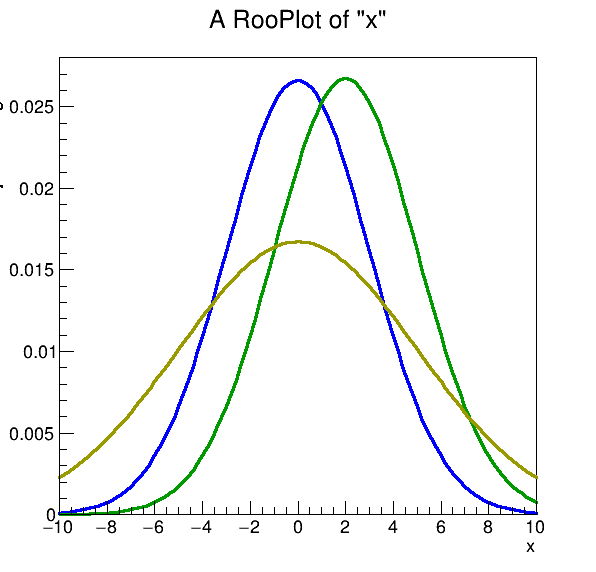

In [11]:
x = ROOT.RooRealVar("x", "x", -10, 10)
m = ROOT.RooRealVar("m", "m", 0, -5, 5)
s = ROOT.RooRealVar("s", "s", 3, 1, 5)

gaus1 = ROOT.RooGaussian("gaus1", "gaus1", x, m, s)

shift = ROOT.RooRealVar("shift", "shift", 2)
f = ROOT.RooFormulaVar("f", "m+shift", ROOT.RooArgSet(m, shift))
gaus2 = ROOT.RooGaussian("gaus2", "gaus2", x, f, s)

shift1 = ROOT.RooRealVar("shift1", "shift1", 2)
f1 = ROOT.RooFormulaVar("f1", "s+shift1", ROOT.RooArgSet(s, shift1))
gaus3 = ROOT.RooGaussian("gaus2", "gaus2", x, m, f1)
canv.Clear()

frame = x.frame()
gaus1.plotOn(frame)
gaus2.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kGreen+2))
gaus3.plotOn(frame, ROOT.RooFit.LineColor(ROOT.kYellow+2))
frame.Draw()
canv.Draw()

# PDF Convolution

Real physics phenomena may not necessarily be modelled by adding different PDFs together, but of a convolution. For example, experimental data, $R(x,a,b)$ is not just formed by the underlying physics theory, $T(x,a)$ but also the detector response, ($D(x,b)$).

$$R(x,a,b) = T(x,a) \otimes D(x,b) = \int_{-\infty}^{\infty}T(x',a)D(x-x',b)dx' $$

## RooFFTConvPdf: Fast Fourier Transform Convolution

Fourier transforms (FT) are a common way to convolve two PDFs. Due to computational limitation, discrete FT (DFT) is used by introducing bins or steps to the underlying variable. From there, the **Fast Fourier Transform** (FFT) algorithm is created to compute DFT.

We would not go to the specifics of the algorithm, thus we leave that as a homework for you. Its fairly trivial.

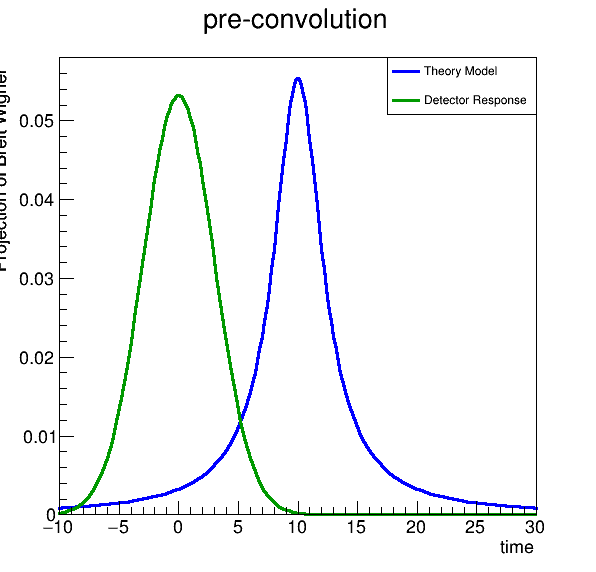

In [46]:
# observable
t = ROOT.RooRealVar("t", "time", -10, 30)

# theory
m_bw = ROOT.RooRealVar("m_bw",   "Breit Wigner mean", 10, 5, 15)
s_bw = ROOT.RooRealVar("s_bw",   "Breit Wigner width", 5, 3, 7)
bw   = ROOT.RooBreitWigner("bw", "Breit Wigner",       t, m_bw, s_bw)
                    
# detector response
m_gaus = ROOT.RooRealVar("m_gaus", "gaussian mean", 0, -5, 5)
s_gaus = ROOT.RooRealVar("s_gaus", "gaussian width", 3, 1, 5)
gaus   = ROOT.RooGaussian("gaus",  "gaussian",       t, m_gaus, s_gaus)

canv.Clear()
preconv = t.frame(ROOT.RooFit.Title("pre-convolution"))
bw.plotOn(preconv, ROOT.RooFit.Name("theory"))
gaus.plotOn(preconv, ROOT.RooFit.LineColor(ROOT.kGreen+2), ROOT.RooFit.Name("detector"))
preconv.Draw()

lgd = ROOT.TLegend(0.65, 0.8, 0.9, 0.9)
lgd.AddEntry("theory", "Theory Model", "l")
lgd.AddEntry("detector", "Detector Response", "l")
lgd.Draw()

canv.Draw()

In [47]:
# FFT sampling frequency
t.setBins(10000, "fft")
                    
# convolution
conv = ROOT.RooFFTConvPdf("conv", "bw x gaus", t, bw, gaus)
                    
# generate toy MC
ds = conv.generate(t, 10000)
                    
# fit the conv pdf to toy dataset
fr = conv.fitTo(ds, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1))

[#1] INFO:Caching -- Changing internal binning of variable 't' in FFT 'conv' from 100 to 930 to improve the precision of the numerical FFT. This can be done manually by setting an additional binning named 'cache'.
[#1] INFO:Eval -- RooRealVar::setRange(t) new range named 'refrange_fft_conv' created with bounds [-10,30]
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(conv) creating new cache 0x7fffef1a7840 with pdf bw_CONV_gaus_CACHE_Obs[t] for nset (t) with code 0
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(conv) creating new cache 0x7fffef099d50 with pdf bw_CONV_gaus_CACHE_Obs[t] for nset (t) with code 0 from preexisting content.
[#1] INFO:Caching -- RooAbsCachedPdf::getCache(conv) creating new cache 0x7fffef099d50 with pdf bw_CONV_gaus_CACHE_Obs[t] for nset (t) with code 0 from preexisting content.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization -- RooMinimizer::optimizeConst: deactivating const optimization


[#1] INFO:Caching -- RooAbsCachedPdf::getCache(conv) creating new cache 0x7fffef099d50 with pdf bw_CONV_gaus_CACHE_Obs[t] for nset (t) with code 0


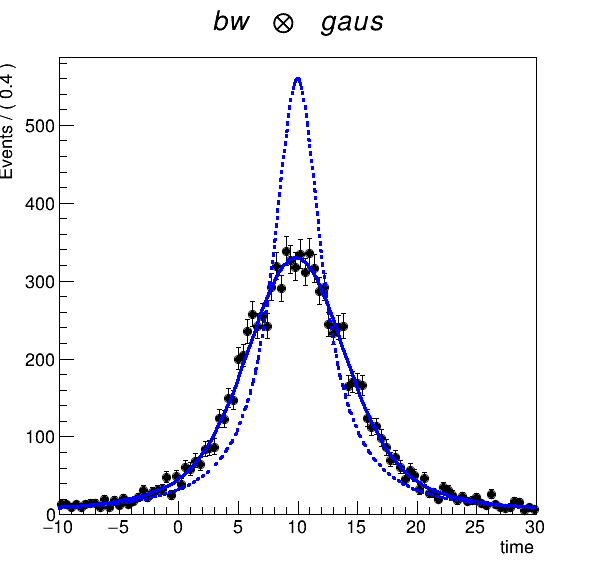

In [48]:
# plot
canv.Clear()
frame = t.frame(ROOT.RooFit.Title("bw$\otimes$gaus"))
ds.plotOn(frame)
conv.plotOn(frame)
bw.plotOn(frame, ROOT.RooFit.LineStyle(ROOT.kDashed))
frame.Draw()
canv.Draw()

# RooProdPdf: Multi-Dimensional Models

As the name states:

In [54]:
x = ROOT.RooRealVar("x", "x", -30, 30)
y = ROOT.RooRealVar("y", "y", -30, 30)

mx = ROOT.RooRealVar("mx", "mx", 10, 5, 15)
sx = ROOT.RooRealVar("sx", "sx", 5, 3, 7)
gx = ROOT.RooGaussian("gx", "gx", x, mx, sx)

my = ROOT.RooRealVar("my", "my", -10, -15, -5)
sy = ROOT.RooRealVar("sy", "sy", 5, 3, 7)
gy = ROOT.RooGaussian("gy", "gy", y, my, sy)

prod = ROOT.RooProdPdf("prod", "gx*gy", ROOT.RooArgSet(gx,gy))

From here, one can generate toy datasets, fit and plot the projection of the 2D PDF we just made.

[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (gx,gy)
[#1] INFO:Minization -- RooMinimizer::optimizeConst: deactivating const optimization
[#1] INFO:Plotting -- RooAbsReal::plotOn(prod) plot on x integrates over variables (y)
[#1] INFO:Plotting -- RooAbsReal::plotOn(prod) plot on y integrates over variables (x)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


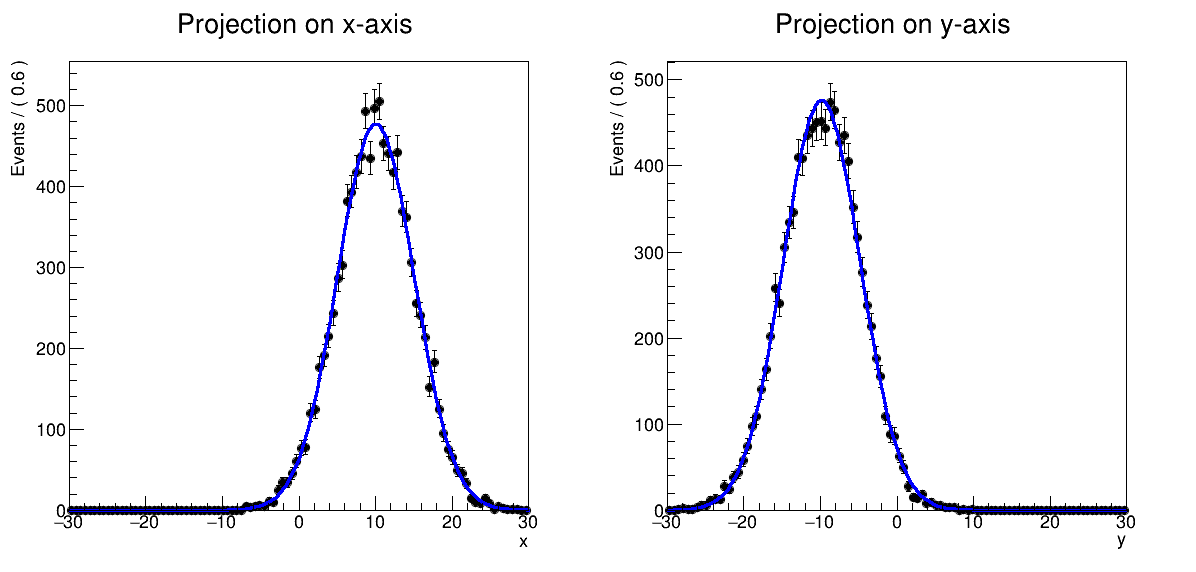

In [59]:
ds = prod.generate(ROOT.RooArgSet(x,y), 10000)
prod.fitTo(ds, ROOT.RooFit.PrintLevel(-1))

xframe = x.frame(ROOT.RooFit.Title("Projection on x-axis"))
ds.plotOn(xframe)
prod.plotOn(xframe)

yframe = y.frame(ROOT.RooFit.Title("Projection on y-axis"))
ds.plotOn(yframe)
prod.plotOn(yframe)

canv = ROOT.TCanvas("canv", "canv", 1200, 600)
canv.Divide(2,1)

canv.cd(1)
xframe.Draw()

canv.cd(2)
yframe.Draw()

canv.Draw()

To visualize the distribution, we can create a TH2F and plot it.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


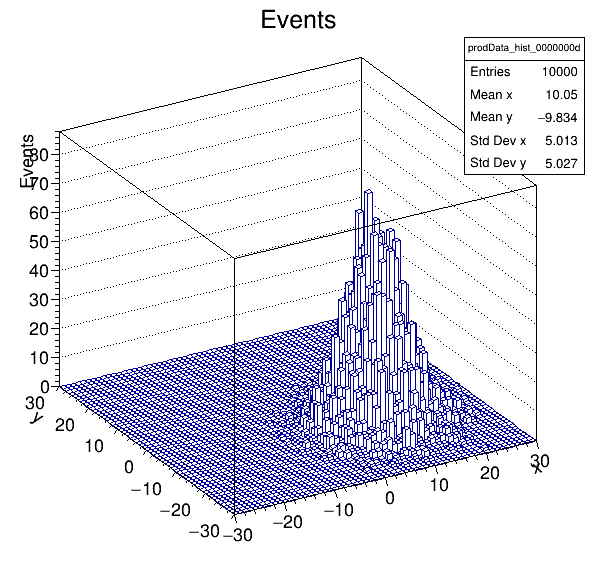

In [83]:
histo = ds.createHistogram(x, y, 60, 60)
histo.GetXaxis().SetTitle("x")
histo.GetYaxis().SetTitle("y")
histo.GetZaxis().SetTitle("Events")

canv = ROOT.TCanvas("canv", "canv", 600,600)
histo.Draw("LEGO")
canv.Draw()

# Discrete States: RooCategory

In certain situations, datasets or models are different in a given state. To cater for different, discrete states, RooFit introduces the **RooCategory** class.

In the example below, we will import a TTree and assign events to datasets according to the value of `ZVCand_mass`.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


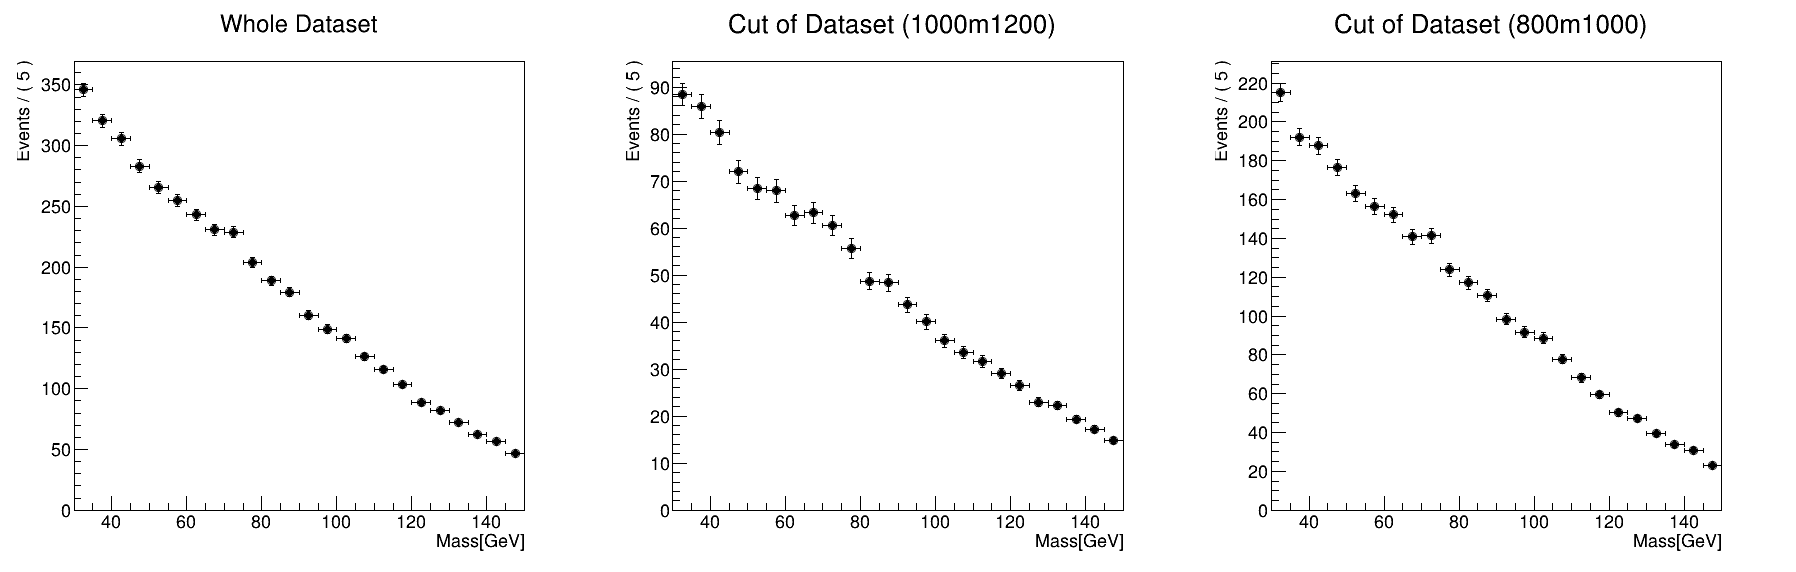

In [91]:
# silencing RooFit operations
ROOT.RooMsgService.instance().setGlobalKillBelow(ROOT.RooFit.FATAL)

# declare a category based upon ZVCand_mass
myCat = ROOT.RooCategory("myCat", "myCat")
myCat.defineType("800m1000")
myCat.defineType("1000m1200")
myCat.defineType("1200m1400")

# extract tree
file = ROOT.TFile("./rootfiles/bkg_main.root", "OPEN")
tree = file.Get("mumu")

# Dataset variables and RooArgSet declaration
ZVCand_mass = ROOT.RooRealVar("ZVCand_mass",        "Mass [GeV]",             0,   8000)
VCand_mass  = ROOT.RooRealVar("VCand_mass_tag",     "Mass[GeV]",             30,    150)
evtWeight   = ROOT.RooRealVar("evtWeight_Final",    "Event Weights",      -1.e9,   1.e9)

varSet = ROOT.RooArgSet(ZVCand_mass, VCand_mass, evtWeight)

# set binning
vBins = int((150-30)/5)
VCand_mass.setBins(vBins)

#
# declare datasets for each category
#

# 800 < ZVCand_mass < 1000
ds0 = ROOT.RooDataSet("ds0", "dataset for 30m60",  varSet, ROOT.RooFit.Import(tree), ROOT.RooFit.WeightVar(evtWeight), \
                      ROOT.RooFit.Cut("ZVCand_mass>800&&ZVCand_mass<1000"))

# 1000 < ZVCand_mass < 1200
ds1 = ROOT.RooDataSet("ds1", "dataset for 60m90",  varSet, ROOT.RooFit.Import(tree), ROOT.RooFit.WeightVar(evtWeight), \
                      ROOT.RooFit.Cut("ZVCand_mass>1000&&ZVCand_mass<1200"))

# 1000 < ZVCand_mass < 1400
ds2 = ROOT.RooDataSet("ds2", "dataset for 90m120", varSet, ROOT.RooFit.Import(tree), ROOT.RooFit.WeightVar(evtWeight), \
                      ROOT.RooFit.Cut("ZVCand_mass>1200&&ZVCand_mass<1400"))

#
# declare an overarching dataset
#
multids = ROOT.RooDataSet("multids", "multi dataset", varSet, ROOT.RooFit.Index(myCat), ROOT.RooFit.WeightVar(evtWeight),\
                          ROOT.RooFit.Import("800m1000", ds0),  \
                          ROOT.RooFit.Import("1000m1200", ds1), \
                          ROOT.RooFit.Import("1200m1400", ds2))
#
# plotting
#
canv = ROOT.TCanvas("canv", "canv", 1800, 600)
canv.Divide(3,1)

canv.cd(1)
vframe1 = VCand_mass.frame(ROOT.RooFit.Title("Whole Dataset"))
multids.plotOn(vframe1)
vframe1.Draw()

canv.cd(2)
vframe2 = VCand_mass.frame(ROOT.RooFit.Title("Cut of Dataset (1000m1200)"))
multids.plotOn(vframe2, ROOT.RooFit.Cut("myCat==myCat::1000m1200"))
vframe2.Draw()

canv.cd(3)
vframe3 = VCand_mass.frame(ROOT.RooFit.Title("Cut of Dataset (800m1000)"))
multids.plotOn(vframe3, ROOT.RooFit.Cut("myCat==myCat::800m1000"))
vframe3.Draw()

canv.Draw()

In this other example, we will generate a toy MC dataset with multiple categories. But, because the model declared was not split into categories, we are unable to slice them.

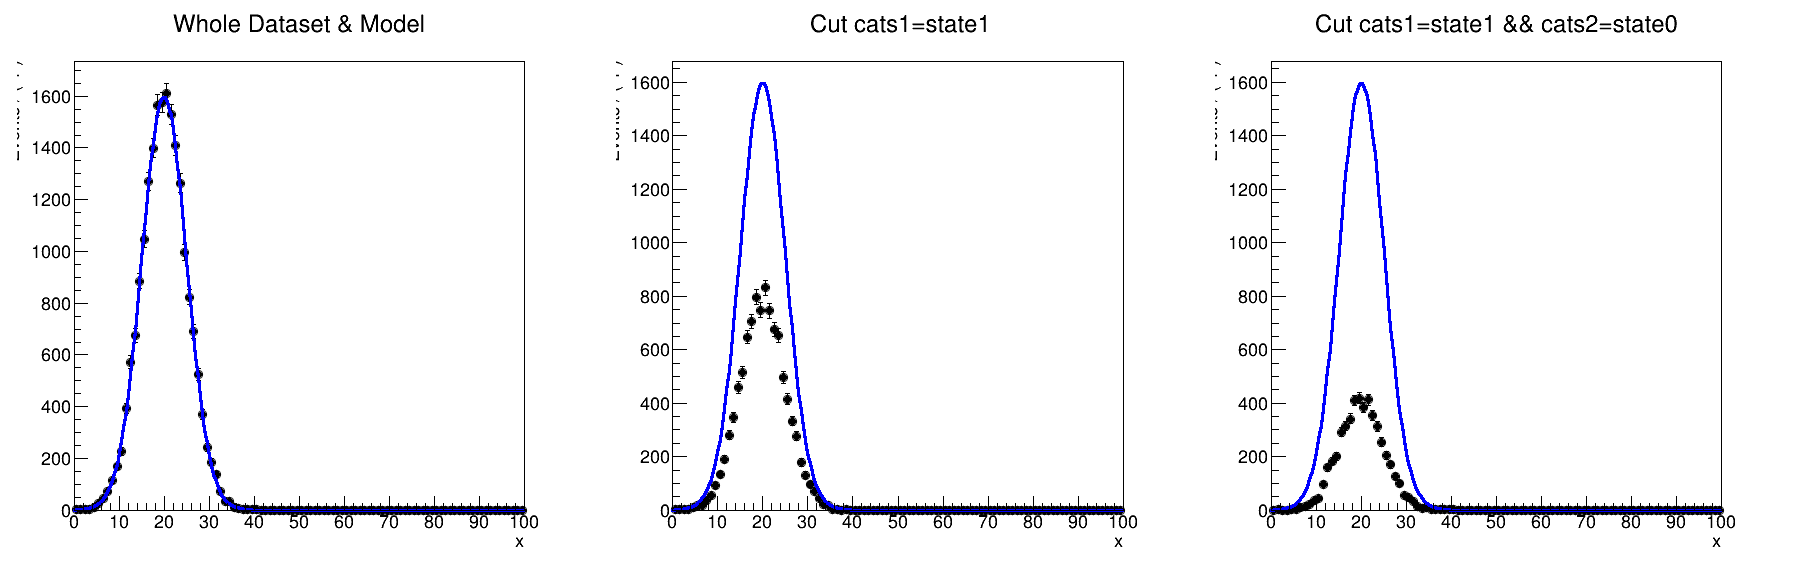

In [106]:
cats1 = ROOT.RooCategory("cats1", "cats1")
cats1.defineType("state0", 0)
cats1.defineType("state1", 1)

cats2 = ROOT.RooCategory("cats2", "cats2")
cats2.defineType("state0", 0)
cats2.defineType("state1", 1)

x = ROOT.RooRealVar("x", "x", 0, 100)
m = ROOT.RooRealVar("m", "m", 20, 10, 30)
s = ROOT.RooRealVar("s", "s", 5, 3, 7)
gaus = ROOT.RooGaussian("gaus", "gaus", x, m, s)

data = gaus.generate(ROOT.RooArgSet(x, cats1, cats2), 20000)
gaus.fitTo(data, ROOT.RooFit.PrintLevel(-1))

canv.Clear()
canv.Divide(3,1)

canv.cd(1)
xframe0 = x.frame(ROOT.RooFit.Title("Whole Dataset & Model"))
data.plotOn(xframe0)
gaus.plotOn(xframe0)
xframe0.Draw()

canv.cd(2)
xframe1 = x.frame(ROOT.RooFit.Title("Cut cats1=state1"))
data.plotOn(xframe1, ROOT.RooFit.Cut("cats1==cats1::state1"))
gaus.plotOn(xframe1, ROOT.RooFit.Slice(cats1, "state1"))
xframe1.Draw()

canv.cd(3)
xframe2 = x.frame(ROOT.RooFit.Title("Cut cats1=state1 && cats2=state0"))
data.plotOn(xframe2, ROOT.RooFit.Cut("cats1==cats1::state0&&cats2==cats2::state1"))
gaus.plotOn(xframe2)
xframe2.Draw()

canv.Draw()

# RooSimultaneous: Simultaneous Fitting

Following from RooCategory, given multiple datasets you may want to fit to them simultaneously too.

In [120]:
# declare RooCategory
cats = ROOT.RooCategory("cats", "cats")
cats.defineType("a")
cats.defineType("b")

# declare two models
x  = ROOT.RooRealVar("x", "x", 0, 100) 

m1 = ROOT.RooRealVar("m1", "m1", 20, 10, 30)
s1 = ROOT.RooRealVar("s1", "s1", 5, 3, 7)
gaus1 = ROOT.RooGaussian("gaus1", "gaus1", x, m1, s1)

m2 = ROOT.RooRealVar("m2", "m2", 20, 10, 30)
s2 = ROOT.RooRealVar("s2", "s2", 10, 1, 20)
gaus2 = ROOT.RooGaussian("gaus2", "gaus2", x, m2, s2)

# # generate toy MC
data1 = gaus1.generate(x, 10000)
data2 = gaus2.generate(x, 10000)

# declare categorised dataset
multiData = ROOT.RooDataSet("multiData", "multiple Datasets", ROOT.RooArgSet(x), ROOT.RooFit.Index(cats), ROOT.RooFit.Import("a", data1), ROOT.RooFit.Import("b", data2))

# declare RooSimultaneous
simulPdf = ROOT.RooSimultaneous("simulPdf", "simultaenous pdf", cats)
simulPdf.addPdf(gaus1, "a")
simulPdf.addPdf(gaus2, "b")

# fitting
fr = simulPdf.fitTo(multiData, ROOT.RooFit.Save(), ROOT.RooFit.PrintLevel(-1))
fr.Print("v")



  RooFitResult: minimized FCN value: 80684.9, estimated distance to minimum: 1.62715e-05
                covariance matrix quality: Full, accurate covariance matrix
                Status : MINIMIZE=0 HESSE=0 

    Floating Parameter  InitialValue    FinalValue +/-  Error     GblCorr.
  --------------------  ------------  --------------------------  --------
                    m1    2.0000e+01    2.0067e+01 +/-  5.04e-02  <none>
                    m2    2.0000e+01    1.9929e+01 +/-  1.11e-01  <none>
                    s1    5.0000e+00    5.0338e+00 +/-  3.57e-02  <none>
                    s2    1.0000e+01    1.0073e+01 +/-  8.73e-02  <none>



Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv


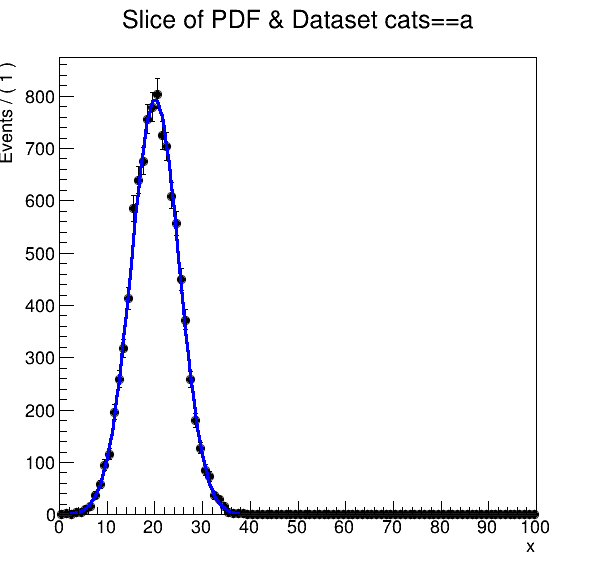

In [124]:
canv = ROOT.TCanvas("canv", "canv", 600, 600)

xframe1 = x.frame(ROOT.RooFit.Title("Slice of PDF & Dataset cats==a"))
multiData.plotOn(xframe1, ROOT.RooFit.Cut("cats==cats::a"))
simulPdf.plotOn(xframe1, ROOT.RooFit.Slice(cats, "a"), ROOT.RooFit.ProjWData(ROOT.RooArgSet(cats), multiData))
xframe1.Draw()
canv.Draw()

# Plotting Fit Results with RooFitResults

When RooFit does the fitting, the error bars of the fit is also available to plot as well.

With the specifeid `VisualizeError()` argument inside the `plotOn()` method for RooAbsPdf, you can specify the error of the fitting.

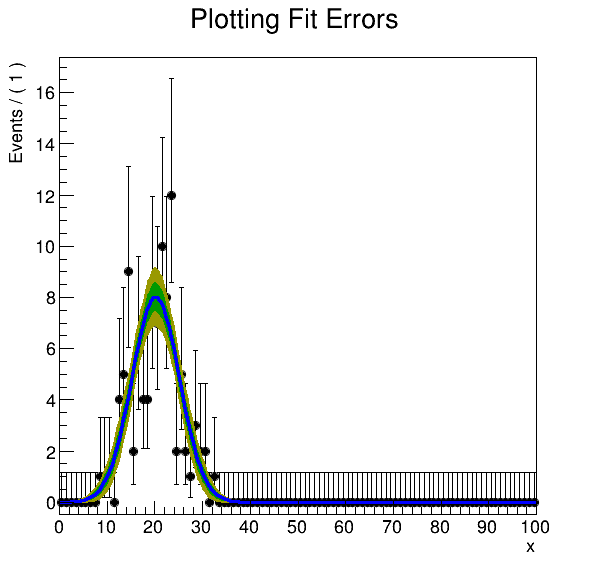

In [142]:
x  = ROOT.RooRealVar("x", "x", 0, 100) 

m = ROOT.RooRealVar("m", "m", 20, 10, 30)
s = ROOT.RooRealVar("s", "s", 5, 3, 7)
gaus = ROOT.RooGaussian("gaus", "gaus", x, m, s)

data = gaus.generate(x, 100)

fr = gaus.fitTo(data, ROOT.RooFit.PrintLevel(-1), ROOT.RooFit.Save())

canv.Clear()
xframe = x.frame(ROOT.RooFit.Title("Plotting Fit Errors"))
data.plotOn(xframe)

# plot the 2 sigma error
gaus.plotOn(xframe, ROOT.RooFit.VisualizeError(fr, 2), \
            ROOT.RooFit.FillColor(ROOT.kYellow+2), ROOT.RooFit.FillStyle(1001), ROOT.RooFit.DrawOption("F"))

# plot the 1 sigma error
gaus.plotOn(xframe, ROOT.RooFit.VisualizeError(fr, 1), \
            ROOT.RooFit.FillColor(ROOT.kGreen+2), ROOT.RooFit.FillStyle(1001), ROOT.RooFit.DrawOption("F"))

gaus.plotOn(xframe)
xframe.Draw()
data.plotOn(xframe)
canv.Draw()